In [2]:
# In this notebook, we derive the mean trajectory, dynamics and measurement models. 
# Prerequisite: x_sample_from_video.npy and y_sample_from_video.npy from the tracking_from_video notebook

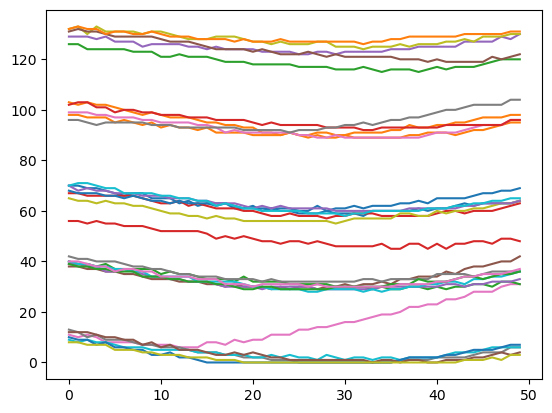

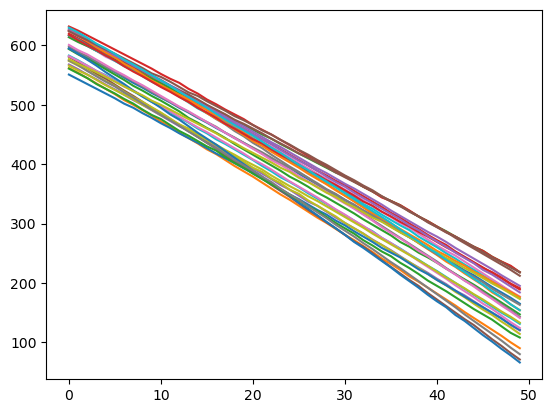

In [3]:
# load the files 

import numpy as np
import matplotlib.pyplot as plt

x_sample = np.load('x_sample_from_video.npy')
y_sample = np.load('y_sample_from_video.npy')

# Plot some trajectories
plt.figure()
for i in range(x_sample.shape[0]):
    plt.plot(x_sample[i,:])

plt.figure()
for i in range(y_sample.shape[0]):
    plt.plot(y_sample[i,:])

In [4]:
# We note down the starting value of each trajectory 
x_start = x_sample[:,0]
y_start = y_sample[:,0]

In [5]:
# Then we subtract the starting value from each trajectory
x_sample_zm = x_sample - x_start[:,None]
y_sample_zm = y_sample - y_start[:,None]

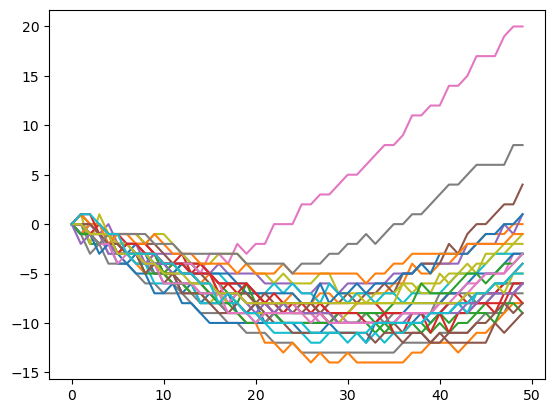

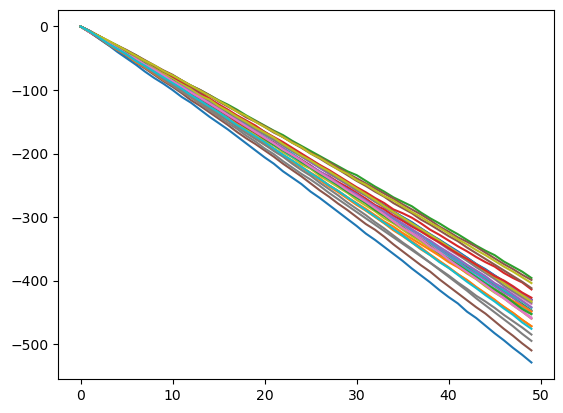

In [6]:
# Plot some trajectories
plt.figure()
for i in range(x_sample_zm.shape[0]):
    plt.plot(x_sample_zm[i,:])

plt.figure()
for i in range(y_sample_zm.shape[0]):
    plt.plot(y_sample_zm[i,:])

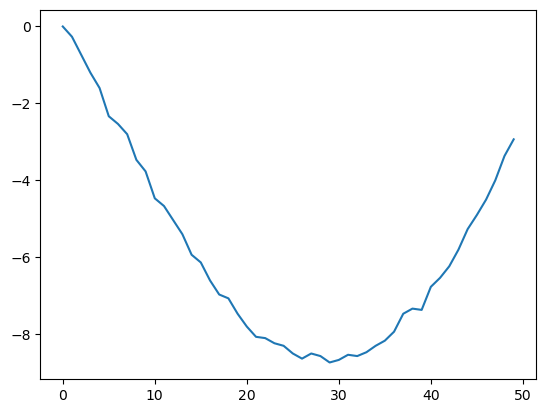

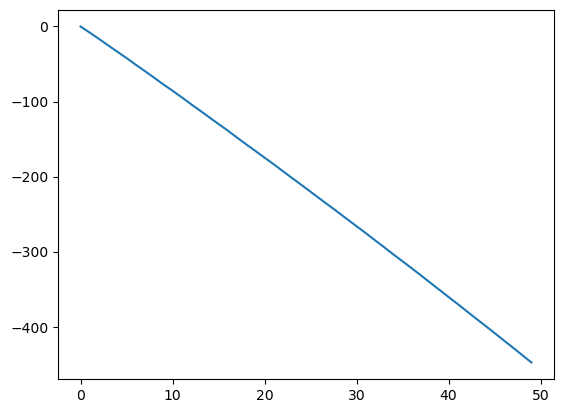

In [7]:
# Compute the mean trajectory for each component of the trajectories

x_mean = np.mean(x_sample_zm, axis=0)
y_mean = np.mean(y_sample_zm, axis=0)

# Plot the mean trajectory
plt.figure()
plt.plot(x_mean)

plt.figure()
plt.plot(y_mean)

In [8]:
# Save the mean trajectories 
np.save('x_mean.npy', x_mean)
np.save('y_mean.npy', y_mean)

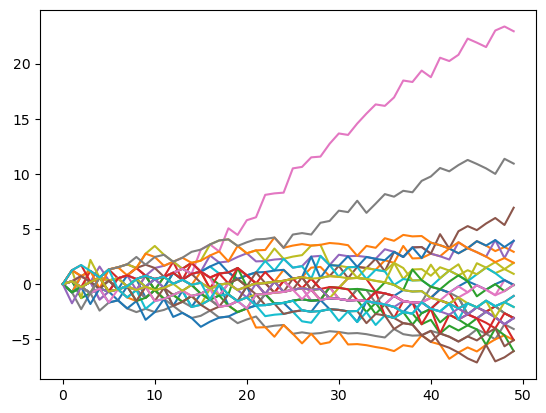

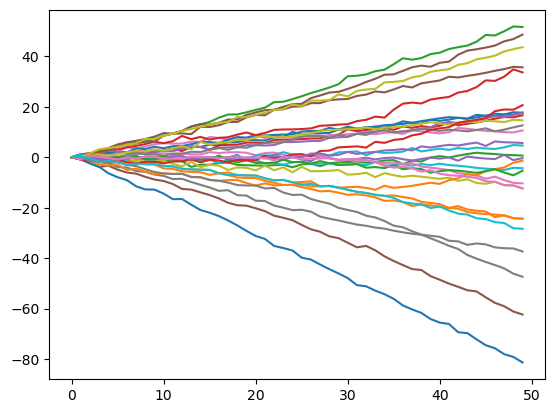

In [9]:
# Compute the residual trajectories
x_res = x_sample_zm - x_mean[None,:]
y_res = y_sample_zm - y_mean[None,:]

# Plot some residual trajectories
plt.figure()
for i in range(x_res.shape[0]):
    plt.plot(x_res[i,:])

plt.figure()
for i in range(y_res.shape[0]):
    plt.plot(y_res[i,:])
    

In [10]:
# Save the residual trajectories
np.save('x_res.npy', x_res)
np.save('y_res.npy', y_res)

# Save the starting values
np.save('x_start.npy', x_start)
np.save('y_start.npy', y_start)

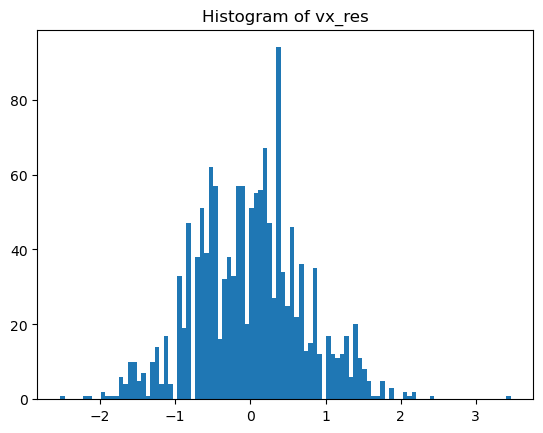

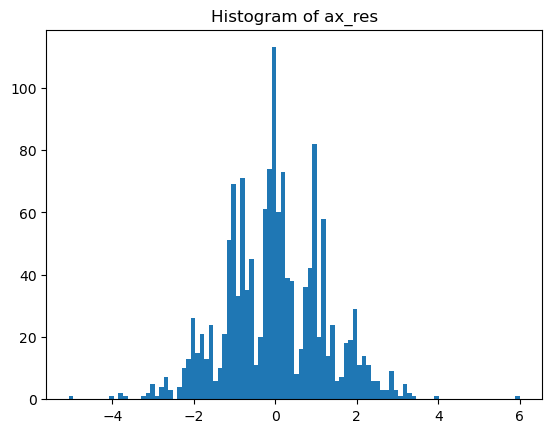

In [13]:
# Take the first derivative of x_res
vx_res = np.diff(x_res, axis=1)
vy_res = np.diff(y_res, axis=1)
# Take the second derivative of y_res
ax_res = np.diff(x_res, axis=1, n=2)

# Histogram of vx_res
plt.figure()
plt.hist(vx_res.flatten(), bins=100)
plt.title('Histogram of vx_res')
plt.show()

# Histogram of ax_res
plt.figure()
plt.hist(ax_res.flatten(), bins=100)
plt.title('Histogram of ax_res')
plt.show()


In [16]:
# Fit a normal distribution to ax_res
from scipy.stats import norm

mu_ax, std_ax = norm.fit(ax_res.flatten())
print('mu_ax = ', mu_ax)
print('std_ax = ', std_ax)

# Fit a Mixture of Gaussians to vx_res
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, covariance_type='full')
gmm.fit(vx_res.flatten()[:,None])

print('mu_vx = ', gmm.means_)
print('std_vx = ', np.sqrt(gmm.covariances_))


mu_ax =  -1.8503717077085942e-18
std_ax =  1.2287923158758585
mu_vx =  [[ 0.99748125]
 [ 0.18829596]
 [-0.63275289]]
std_vx =  [[[0.50898701]]

 [[0.34824078]]

 [[0.48953773]]]


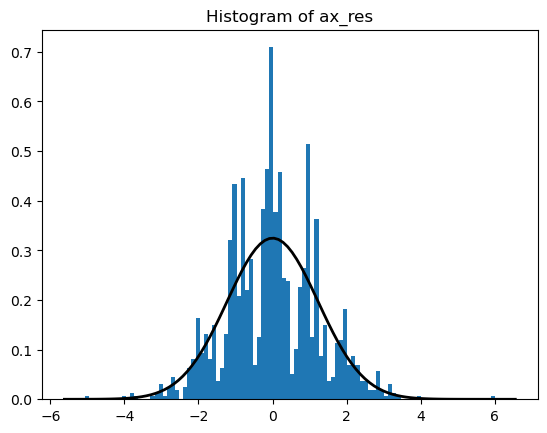

In [17]:
# Plot the PDF of the fitted normal distribution
plt.figure()
plt.hist(ax_res.flatten(), bins=100, density=True)
xmin, xmax = plt.xlim()

x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_ax, std_ax)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Histogram of ax_res')
plt.show()

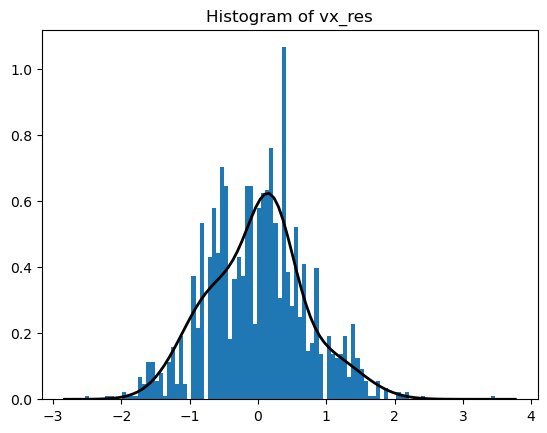

In [18]:
# Plot the PDF of the fitted Mixture of Gaussians
plt.figure()
plt.hist(vx_res.flatten(), bins=100, density=True)
xmin, xmax = plt.xlim()

x = np.linspace(xmin, xmax, 100)
p = gmm.score_samples(x[:,None])
plt.plot(x, np.exp(p), 'k', linewidth=2)
plt.title('Histogram of vx_res')
plt.show()


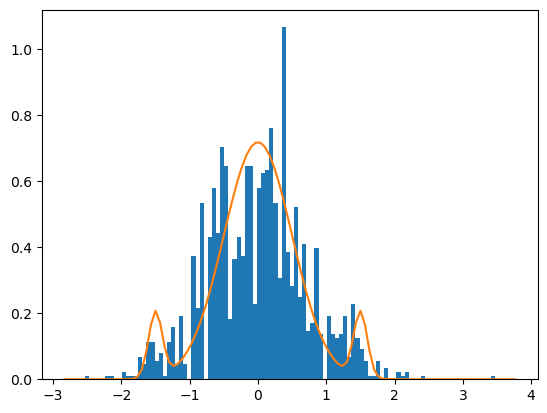

In [25]:
def slipping_pdf(alpha_left, mu_left, std_left, alpha_center, mu_center, std_center, alpha_right, mu_right, std_right, x):
    return (alpha_left * norm.pdf(x, mu_left, std_left) + alpha_center * norm.pdf(x, mu_center, std_center) + alpha_right * norm.pdf(x, mu_right, std_right))

# Plot the PDF of the fitted Mixture of Gaussians
plt.figure()
plt.hist(vx_res.flatten(), bins=100, density=True)
xmin, xmax = plt.xlim()

x = np.linspace(xmin, xmax, 100)
plt.plot(x, slipping_pdf(alpha_left = 0.05, mu_left = -1.5, std_left = 0.1, 
                         alpha_center = 0.9, mu_center = 0, std_center = 0.5, alpha_right = 0.05, mu_right = 1.5, std_right = 0.1, x = x))
plt.show()


In [26]:
# With the dynamics model ready, we can go ahead and implement the GMKF.